# Notebook Modelisation


1. Equilibrer les classes( smooth)

2. Comparer les modeles avec nos metriques (La sensibilite, accuracy, recall, auc)

3. Estimer le coef optimal pour la classe des risquées (courbe roc, recap semaine derniére)

4. Interpretabilite des modéles, (package shape) contribution des variables 

5. Derniere etape sauvegarder le dernier model avec joblib




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
!pip install imblearn
!pip install shap 
!pip install joblib
# !pip install pycaret


In [ ]:
joblib.__version__

'1.1.0'

In [ ]:
!pip inst

In [15]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import gc


from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


import matplotlib.pyplot as plt
from sklearn import metrics
import os

output_data_dir = os.getcwd() + "/../data_cleaned/"
input_data_dir = os.getcwd() + "/../data_cleaned/"

# !pip install lightgbm

In [16]:
app_train = pd.read_csv(input_data_dir + 'app_train_cleaned.csv')

In [3]:
app_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1,0,1,0,1,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,1,0,0,False,4.790750,0.132217,0.027598,-0.070862
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,False,4.222222,0.179963,0.042623,-0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,1,0,1,0,0,False,1.617143,0.174971,0.108198,-0.025303
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,1,0,1,0,0,True,3.743750,0.166687,0.044524,NaN
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,0,0,1,0,0,False,4.429176,0.195941,0.044239,-0.529266
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,1,0,1,0,1,False,2.164368,0.118158,0.054592,-0.400134


#

In [4]:

def clean(app_train):

  # Drop the target from the training data
  columnsSupp = []

  # if 'SK_ID_CURR' in app_train:
  #     columnsSupp.append('SK_ID_CURR')


  if 'TARGET' in app_train:
      columnsSupp.append('TARGET')

  if len(columnsSupp) > 0:
    train = app_train.drop(columns = columnsSupp)
  else:
    train = app_train
      
  # train = app_train.drop(columns = columnsSupp)
  
  features_training = train.columns.values

  # Feature names
  features = list(train.columns)

  # Copy of the testing data

  # Median imputation of missing values
  imputer = SimpleImputer(strategy = 'median')

  # Scale each feature to 0-1
  scaler = MinMaxScaler(feature_range = (0, 1))

  # Fit on the training data
  imputer.fit(train)

  # Transform both training and testing data
  train = imputer.transform(train)
  # Repeat with the scaler
  scaler.fit(train)
  # X = scaler.transform(train)
  # y = app_train['TARGET'].values 
  X = scaler.transform(train)
  y = app_train['TARGET']
  
  X = pd.DataFrame(data=X, columns=features_training) 
  
  return X, y, features_training
    
    
def smote(X, y):
  sm = SMOTE(random_state=42)

  X_res, y_res = sm.fit_resample(X, y)

  return X_res, y_res


def split_training(X, y, n = 10000):
  """
  Transform le jeu de donnée en jeu d'entrainent et de test
  """

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.33, random_state=42)
  
  return X_train, X_test, y_train, y_test


def clean_smote_split(app_train):
  X, y = clean(app_train.copy())
  X, y = smote(X, y)
  return split_training(X, y)



In [5]:
X, y, features_training = clean(app_train.sample(n=10000))
X, y = smote(X, y)
X_train, X_test, y_train, y_test = split_training(X, y)

In [ ]:
# X, y, features = clean(app_train.sample(n=10000))
# X, y = smote(X, y)
# df_export = pd.DataFrame(data=X, columns = features)
# df_export['TARGET'] = y
# df_export.to_csv('data_cleaned.csv')

In [ ]:
# print(len(X[0]))
# print(len(X_train[0]))

243
243


In [ ]:
# df_export.shape

(18400, 244)

In [54]:
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
 
	return X_train_fs, X_test_fs, fs, fs.get_support()


def get_metrics_classification(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_pred)
  classification = classification_report(y_true, y_pred)
  return accuracy, roc, classification



def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

from sklearn.metrics import confusion_matrix
################################################################################################
def conf_matrix(y_true, y_pred):
    
    mat = confusion_matrix(y_true, y_pred)
    
    print('Confusion Matrix:\n', mat)
    
    labels = ['Payed: 0', 'Unpayed: 1']
    
    sns.heatmap(mat, 
                square=True,
                annot=True,
                fmt='d',
                cbar=False,
                xticklabels=labels,
                yticklabels=labels,
               )
    
    plt.xlabel('Predicted (true label)')
    plt.ylabel('Expected (predicted label)')
    plt.show()

# Feature selection with anova

---

Faire le pipeline complet avec toutes les variables

Selectionner le meilleur modéle avant de réduire le nombre de variables 

Faire une boucle : 
* Augmenter le nombre de variable utilisé a chaque itération
* Stocker les metrics pour chaque



Feature NAME_CONTRACT_TYPE: 2842.945636
Feature FLAG_OWN_CAR: 1351.571362
Feature FLAG_OWN_REALTY: 113.512993
Feature CNT_CHILDREN: 597.889880
Feature AMT_INCOME_TOTAL: 15.002686
Feature AMT_CREDIT: 1750.402552
Feature AMT_ANNUITY: 353.616594
Feature AMT_GOODS_PRICE: 3088.285935
Feature REGION_POPULATION_RELATIVE: 2958.553275
Feature DAYS_BIRTH: 8475.102933
Feature DAYS_EMPLOYED: 7910.604132
Feature DAYS_REGISTRATION: 2989.872654
Feature DAYS_ID_PUBLISH: 3602.611398
Feature OWN_CAR_AGE: 168.325968
Feature FLAG_MOBIL: 1.000870
Feature FLAG_EMP_PHONE: 3071.472334
Feature FLAG_WORK_PHONE: 249.694214
Feature FLAG_CONT_MOBILE: 49.457319
Feature FLAG_PHONE: 2354.252473
Feature FLAG_EMAIL: 604.812366
Feature CNT_FAM_MEMBERS: 329.936980
Feature REGION_RATING_CLIENT: 5115.542130
Feature REGION_RATING_CLIENT_W_CITY: 5620.151261
Feature HOUR_APPR_PROCESS_START: 1181.706656
Feature REG_REGION_NOT_LIVE_REGION: 23.426099
Feature REG_REGION_NOT_WORK_REGION: 65.241406
Feature LIVE_REGION_NOT_WORK_REGI

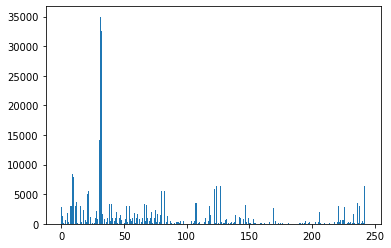

Moyenne : 1194.7473099076863
Ecart type : 3425.866548486785


In [ ]:
from matplotlib import pyplot
# feature selection

fs = SelectKBest(score_func=f_classif)
	# learn relationship from training data
fs.fit(X_train, y_train)
features_training = app_train.columns.values
for i in range(len(fs.scores_)):
	
	print('Feature %s: %f' % (features_training[i], fs.scores_[i]))
 
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

print("Moyenne : " + str(np.mean(fs.scores_)))
print("Ecart type : " + str(np.std(fs.scores_)))

In [ ]:
X_train_fs, X_test_fs, fs, mask = select_features(X_train, y_train, X_test)

features_name = np.ma.MaskedArray(features_training, mask=~mask)
features_name = features_name.tolist()
features_name = [x for x in features_name if x is not None]

# what are scores for the features
print(X_train_fs.shape)
print(X_train.shape)
print(features_name)

(378799, 10)
(378799, 243)
['DAYS_BIRTH', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'DAYS_EMPLOYED_PERCENT']


In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

def get_metrics(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_pred)
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  df = pd.DataFrame(data = [[precision, acc, recall, f1]], columns=['precision', 'accuracy', 'recall', 'f1_score'])
  # print(classification_report(y_true, y_pred))
  # print("optimal treshold=" + str(optimal_roc(tpr, fpr, thresholds)))
  # print(df)
  # print("roc=" + str(roc))
  # print(fpr, tpr, thresholds)
  # plot_roc_curve(fpr, tpr)
  return df, tpr, fpr, thresholds

def optimal_roc(tpr, fpr, thresholds):
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  return optimal_threshold


def model(algorithm, parameters):
  """
  Crée une grid entrainte le model affiche les resultats et retourne les resultats
  algorithm: Linear, RandomForest compatatible avec gridsearch
  parameters: parametres pour l'entrainement du model
  """
  scoring_metrics = [ 'roc_auc', 'recall', 'precision', 'accuracy']

  # grid_pipeline = GridSearchCV(algorithm, parameters, scoring= scoring_metrics, n_jobs=-1, refit='accuracy', return_train_score=True, cv =3)
  grid_pipeline = GridSearchCV(algorithm, parameters,  n_jobs=-1, refit=True, return_train_score=True, cv =3)


  grid_pipeline.fit(X_train, y_train)

  y_pred_grid = grid_pipeline.predict(X_test)

  df_metrics, tpr, fpr, thresholds = get_metrics(y_test, y_pred_grid)

  conf_matrix(y_test, y_pred_grid)
  
  return grid_pipeline, df_metrics, tpr, fpr, thresholds



def model2(algorithm, parameters, X_train, X_test, y_train, y_test):
  """
  Crée une grid entrainte le model affiche les resultats et retourne les resultats
  algorithm: Linear, RandomForest compatatible avec gridsearch
  parameters: parametres pour l'entrainement du model
  """
  scoring_metrics = [ 'roc_auc', 'recall', 'precision', 'accuracy']

  # grid_pipeline = GridSearchCV(algorithm, parameters, scoring= scoring_metrics, n_jobs=-1, refit='accuracy', return_train_score=True, cv =3)
  grid_pipeline = GridSearchCV(algorithm, parameters,  n_jobs=-1, refit=True, return_train_score=True, cv =3)


  grid_pipeline.fit(X_train, y_train)

  y_pred_grid = grid_pipeline.predict(X_test)

  df_metrics, tpr, fpr, thresholds = get_metrics(y_test, y_pred_grid)

  # conf_matrix(y_test, y_pred_grid)
  
  return grid_pipeline, df_metrics, tpr, fpr, thresholds

# GridSearchCv sur regression lineaire

Confusion Matrix:
 [[2180  877]
 [ 778 2234]]


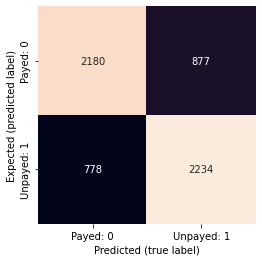

(GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
              param_grid={'C': [0.5, 0.001, 0.1], 'max_iter': [1000]},
              return_train_score=True),
    precision  accuracy  recall  f1_score
 0   0.718097  0.727303  0.7417  0.729708,
 array([0.        , 0.74169987, 1.        ]),
 array([0.        , 0.28688256, 1.        ]),
 array([2, 1, 0]))

In [87]:


parameters = {
  'C': [0.5, 0.001, 0.1],
  'max_iter': [1000]
}

model(LogisticRegression(), parameters)






# Random Forest


Confusion Matrix:
 [[2744  304]
 [ 314 2720]]


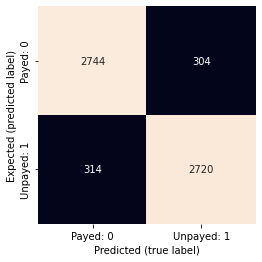

In [56]:

parameters = {
  'n_estimators': [100],
  "max_depth": [2, 3, 5, 7],
  # 'n_estimators': [100, 250, 500],
  'n_jobs': [-1]
}

grid_pipeline = model(RandomForestClassifier(), parameters)


# Optimal treshold estimation

In [45]:
grid_pipeline

(GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              param_grid={'max_depth': [2, 3, 5, 7], 'n_estimators': [100],
                          'n_jobs': [-1]},
              return_train_score=True),
    precision  accuracy    recall  f1_score
 0   0.891175   0.89102  0.890288  0.890731,
 array([0.        , 0.89028837, 1.        ]),
 array([0.        , 0.10825083, 1.        ]),
 array([2, 1, 0]))

In [6]:
# random_forest = grid_pipeline.best_estimator_
random_forest = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth= 7)
random_forest.fit(X_train, y_train)





RandomForestClassifier(max_depth=7, n_estimators=500, n_jobs=-1)

In [7]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns.values, 'importance': feature_importance_values})
feature_importances.sort_values(by='importance', ascending=False)

,feature,importance
33,EXT_SOURCE_3,0.080769
32,EXT_SOURCE_2,0.050044
77,OBS_30_CNT_SOCIAL_CIRCLE,0.046501
107,AMT_REQ_CREDIT_BUREAU_YEAR,0.043743
79,OBS_60_CNT_SOCIAL_CIRCLE,0.041946
...,...,...
95,FLAG_DOCUMENT_15,0.000000
202,ORGANIZATION_TYPE_Religion,0.000000
217,ORGANIZATION_TYPE_Transport: type 1,0.000000
101,FLAG_DOCUMENT_21,0.000000


In [13]:
# feature_importance_values
random_forest

filename = output_data_dir + 'random_forest_model.sav'
joblib.dump(random_forest, filename)

['/home/brandon/projets/openclassroom/P7/modelisation/../data_cleaned/random_forest_model.sav']

'/home/brandon/projets/openclassroom/P7/modelisation/../data_cleaned/'

# XgBoost


Confusion Matrix:
 [[3023   41]
 [ 258 2770]]


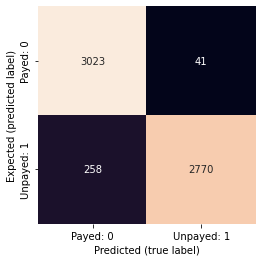

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

parameters = {
  'learning_rate': [0.1],
  'max_depth': [5],
  'n_estimators': [10, 25, 50]
}

grid_pipeline_xgboost = model(xgb.XGBClassifier(), parameters)


In [ ]:
grid_pipeline_xgboost

(GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
              param_grid={'learning_rate': [0.1], 'max_depth': [5],
                          'n_estimators': [10, 25, 50]},
              return_train_score=True),
    precision  accuracy    recall  f1_score
 0   0.985414  0.950919  0.914795  0.948793,
 array([0.        , 0.91479524, 1.        ]),
 array([0.       , 0.0133812, 1.       ]),
 array([2, 1, 0]))

# Extra tree classifier

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parall

optimal treshold=1
   precision  accuracy    recall  f1_score
0   0.756709    0.7656  0.775374  0.765928
roc=0.7657044317649211
[0.         0.24396518 1.        ] [0.         0.77537404 1.        ] [2 1 0]


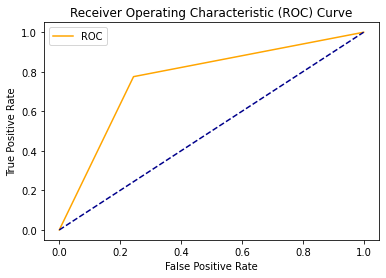

Confusion Matrix:
 [[3821 1233]
 [1111 3835]]


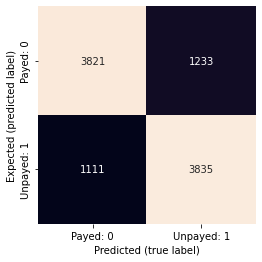

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
parameters = {
    'max_depth': [2, 5, 10],
    'min_samples_split': [1, 2]
}

grid_extra_tree = model(ExtraTreesClassifier(), parameters)

# Decision Tree Classifier

optimal treshold=1
   precision  accuracy    recall  f1_score
0    0.79613    0.7962  0.790336  0.793222
roc=0.7961373414595079
[0.         0.19806094 1.        ] [0.         0.79033562 1.        ] [2 1 0]


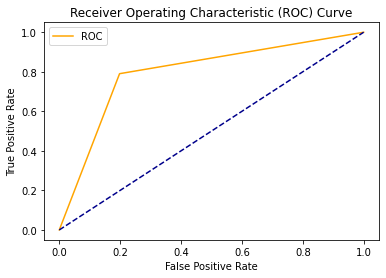

Confusion Matrix:
 [[4053 1001]
 [1037 3909]]


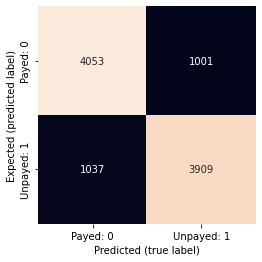

In [ ]:
from sklearn.tree import DecisionTreeClassifier


parameters = {
    
}

decision_pipeline = model(DecisionTreeClassifier(), parameters)


Le meilleur modèle est Random Forest avec une accuracy à 0.95

https://stackoverflow.com/questions/49345578/how-to-decide-threshold-value-in-selectfrommodel-for-selecting-features

In [ ]:
feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances.max())
print(feature_importances[feature_importances.importance !=0].min())
print(feature_importances[feature_importances.importance !=0].shape)

feature       YEARS_BUILD_MODE
importance           0.0481572
dtype: object
feature       AMT_ANNUITY
importance    1.33735e-06
dtype: object
(236, 2)


In [62]:
from sklearn import feature_selection

def getFeaturesFromSelectionModel(model, X_train, Y_train, X_colonnes, aSeuils = np.arange(0, 0.5, 1).tolist()):
  
    aData = []
    for seuil in aSeuils:
        selector = feature_selection.SelectFromModel(estimator=model, threshold = seuil)
        selector.fit_transform(X_train, Y_train)
        aMeilleuresColonnes = selector.get_support(True)
        X_best_features = X_colonnes[aMeilleuresColonnes]
        aData.append([seuil, X_best_features, len(X_best_features)])
        
    df_retour = pd.DataFrame(data= aData, columns=['seuil', 'Meilleures caractéristiques', "Nombre de caractéristiques"])

    return df_retour


def calcul_features(app_train, aSeuils = []):
  X, y, features = clean(app_train.sample(n=10000))
  X, y = smote(X, y)
  X_train, X_test, y_train, y_test = split_training(X, y)


  print("debut de la selection des caractéristiques")
  df_features = getFeaturesFromSelectionModel(RandomForestClassifier(n_estimators=500), X_train, y_train, features, aSeuils)
  params_training = {
      "n_estimators": [100],
      "max_depth": [2, 3, 5, 7]
  }

  print("debut de calcul des metrics")
  metrics_list = []
  for seuil in aSeuils:
    grid_pipeline, df_metrics, tpr, fpr, thresholds = model2(RandomForestClassifier(), params_training, X_train, X_test, y_train, y_test)
    metrics_list.append(df_metrics.to_dict('records')[0])
  
  df_metrics_global = pd.DataFrame(metrics_list)
  return pd.concat([df_features, df_metrics_global], axis=1, join='inner')


In [63]:
aSeuils = np.arange(0.0, 	0.015, 0.004)

df_metrics = calcul_features(app_train, aSeuils)

print(df_metrics)

debut de la selection des caractéristiques
debut de calcul des metrics
   seuil                        Meilleures caractéristiques  ...    recall  f1_score
0  0.000  [SK_ID_CURR, NAME_CONTRACT_TYPE, FLAG_OWN_CAR,...  ...  0.911774  0.900278
1  0.004  [SK_ID_CURR, NAME_CONTRACT_TYPE, FLAG_OWN_CAR,...  ...  0.901824  0.895881
2  0.008  [SK_ID_CURR, FLAG_OWN_CAR, FLAG_OWN_REALTY, CN...  ...  0.906468  0.898570
3  0.012  [SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A...  ...  0.900829  0.895188

[4 rows x 7 columns]


In [64]:
df_metrics

,seuil,Meilleures caractéristiques,Nombre de caractéristiques,precision,accuracy,recall,f1_score
0,0.000,"[SK_ID_CURR, NAME_CONTRACT_TYPE, FLAG_OWN_CAR,...",244,0.889069,0.899737,0.911774,0.900278
1,0.004,"[SK_ID_CURR, NAME_CONTRACT_TYPE, FLAG_OWN_CAR,...",65,0.890016,0.895950,0.901824,0.895881
2,0.008,"[SK_ID_CURR, FLAG_OWN_CAR, FLAG_OWN_REALTY, CN...",38,0.890808,0.898419,0.906468,0.898570
3,0.012,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A...",26,0.889617,0.895291,0.900829,0.895188


In [ ]:
features_general = result.iloc[14]["Meilleures caractéristiques"]

columns_supp = np.setdiff1d(app_train.columns.values, features_general)
columns_supp = columns_supp[columns_supp != "TARGET"]

app_simplifier = app_train.drop(columns_supp, axis=1)


print(app_simplifier.columns.values)

['CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT' 'AMT_ANNUITY'
 'AMT_GOODS_PRICE' 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH'
 'DAYS_EMPLOYED' 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'CNT_FAM_MEMBERS'
 'REGION_RATING_CLIENT' 'REGION_RATING_CLIENT_W_CITY'
 'HOUR_APPR_PROCESS_START' 'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOURCE_3'
 'OBS_30_CNT_SOCIAL_CIRCLE' 'DEF_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'DAYS_LAST_PHONE_CHANGE'
 'AMT_REQ_CREDIT_BUREAU_YEAR' 'TARGET' 'CREDIT_INCOME_PERCENT'
 'ANNUITY_INCOME_PERCENT' 'CREDIT_TERM' 'DAYS_EMPLOYED_PERCENT']


In [ ]:
app_simplifier


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637.0,-3648.0,-2120,1.0,2,2,10,0.083037,0.262949,0.139376,2.0,2.0,2.0,-1134.0,1.0,1,2.007889,0.121978,0.060749,-0.067329
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188.0,-1186.0,-291,2.0,1,1,11,0.311267,0.622246,NaN,1.0,0.0,1.0,-828.0,0.0,0,4.790750,0.132217,0.027598,-0.070862
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225.0,-4260.0,-2531,1.0,2,2,9,NaN,0.555912,0.729567,0.0,0.0,0.0,-815.0,0.0,0,2.000000,0.100000,0.050000,-0.011814
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039.0,-9833.0,-2437,2.0,2,2,17,NaN,0.650442,NaN,2.0,0.0,2.0,-617.0,NaN,0,2.316167,0.219900,0.094941,-0.159905
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038.0,-4311.0,-3458,1.0,2,2,11,NaN,0.322738,NaN,0.0,0.0,0.0,-1106.0,0.0,0,4.222222,0.179963,0.042623,-0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.0,254700.0,27558.0,225000.0,0.032561,9327,-236.0,-8456.0,-1982,1.0,1,1,15,0.145570,0.681632,NaN,0.0,0.0,0.0,-273.0,NaN,0,1.617143,0.174971,0.108198,-0.025303
307507,0,72000.0,269550.0,12001.5,225000.0,0.025164,20775,NaN,-4388.0,-4090,1.0,2,2,8,NaN,0.115992,NaN,0.0,0.0,0.0,0.0,NaN,0,3.743750,0.166687,0.044524,NaN
307508,0,153000.0,677664.0,29979.0,585000.0,0.005002,14966,-7921.0,-6737.0,-5150,1.0,3,3,9,0.744026,0.535722,0.218859,6.0,0.0,6.0,-1909.0,1.0,0,4.429176,0.195941,0.044239,-0.529266
307509,0,171000.0,370107.0,20205.0,319500.0,0.005313,11961,-4786.0,-2562.0,-931,2.0,2,2,9,NaN,0.514163,0.661024,0.0,0.0,0.0,-322.0,0.0,1,2.164368,0.118158,0.054592,-0.400134


In [67]:
df_metrics

,seuil,Meilleures caractéristiques,Nombre de caractéristiques,precision,accuracy,recall,f1_score
0,0.000,"[SK_ID_CURR, NAME_CONTRACT_TYPE, FLAG_OWN_CAR,...",244,0.889069,0.899737,0.911774,0.900278
1,0.004,"[SK_ID_CURR, NAME_CONTRACT_TYPE, FLAG_OWN_CAR,...",65,0.890016,0.895950,0.901824,0.895881
2,0.008,"[SK_ID_CURR, FLAG_OWN_CAR, FLAG_OWN_REALTY, CN...",38,0.890808,0.898419,0.906468,0.898570
3,0.012,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A...",26,0.889617,0.895291,0.900829,0.895188


In [73]:
!pip install shap

# Interpretabilité du modéle

In [90]:
# compute SHAP values
# explainer = shap.Explainer(random_forest)
# shap_values = explainer(X_train_fs[0: 10000], X_test[0:10000])


import shap

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.predict(X_test[0:100])

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [91]:
explainer = shap.TreeExplainer(rf)
shap_values  = explainer.shap_values(X_train[0:100])
# shap.summary_plot(shap_values, X_train[0:100], plot_type="bar")

In [76]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test[2])

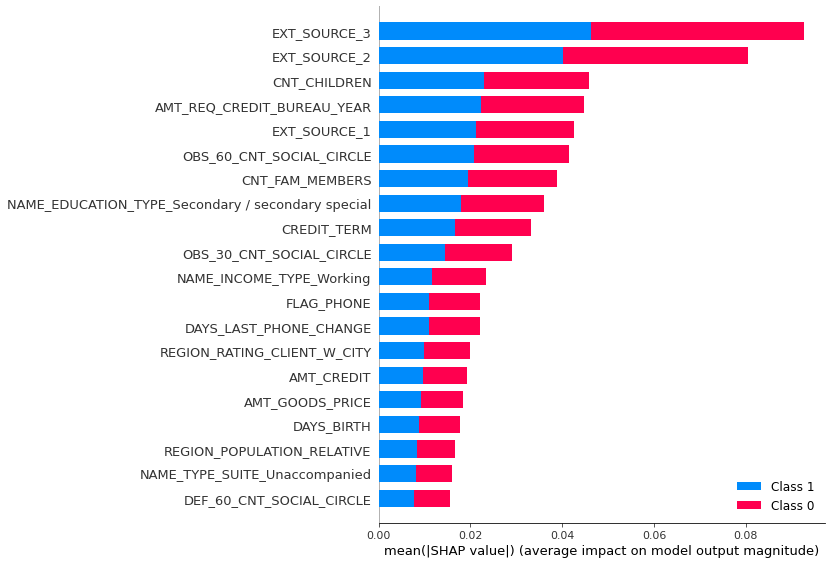

In [92]:
shap.summary_plot(shap_values, X_train[0:100])

Ceci est le graphique expliquant notre modéle,
ce qui serait intéressant de faire est d'avoir le même modéle mais avec les caractéristiques du client

In [ ]:
shap.plots.beeswarm(shap_values)

accurary = 0.6797017789283551
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     93370
           1       0.67      0.69      0.68     93203

    accuracy                           0.68    186573
   macro avg       0.68      0.68      0.68    186573
weighted avg       0.68      0.68      0.68    186573

roc score 0.6797139527525469


[0.         0.33369391 1.        ]
[0.         0.69293907 1.        ]
[2 1 0]


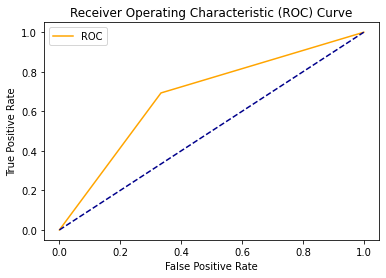

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
print(fpr)
print(tpr)
print(thresholds)
plot_roc_curve(fpr, tpr)

The Area Under the Curve (AUC) is used to compare classifiers. A perfect classifier will have an area under the ROC curve equal to 1, meanwhile, a perfectly random classifier will have an AUC of 0.5.


# Sauvegarde du modéle 

In [ ]:
filename = 'finalized_model.sav'
joblib.dump(log_reg, filename)



In [18]:
X1, y1, features1 = clean(app_train.sample(10000))

X1['TARGET'] = y1

X1.to_csv(output_data_dir + "app_train_cleaned_sous_echantillon.csv", index=False)